In [4]:
import cv2
import random
import numpy as np
from pathlib import Path
import einops
import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [10]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [11]:
n_frames = 10
batch_size = 8

teste_dir = Path('drive/MyDrive/projeto_cv/teste_de_frames')


output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

teste_ds = tf.data.Dataset.from_generator(FrameGenerator(teste_dir, n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
teste_ds = teste_ds.batch(batch_size)


Displaying frames for the first two videos:
Video 1:


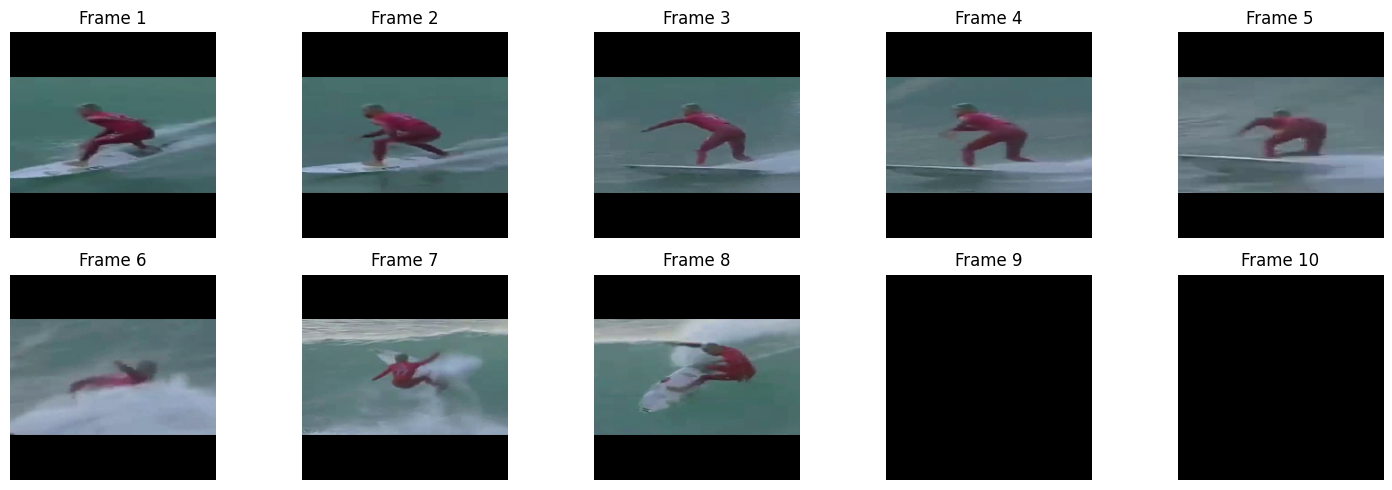

Video 2:


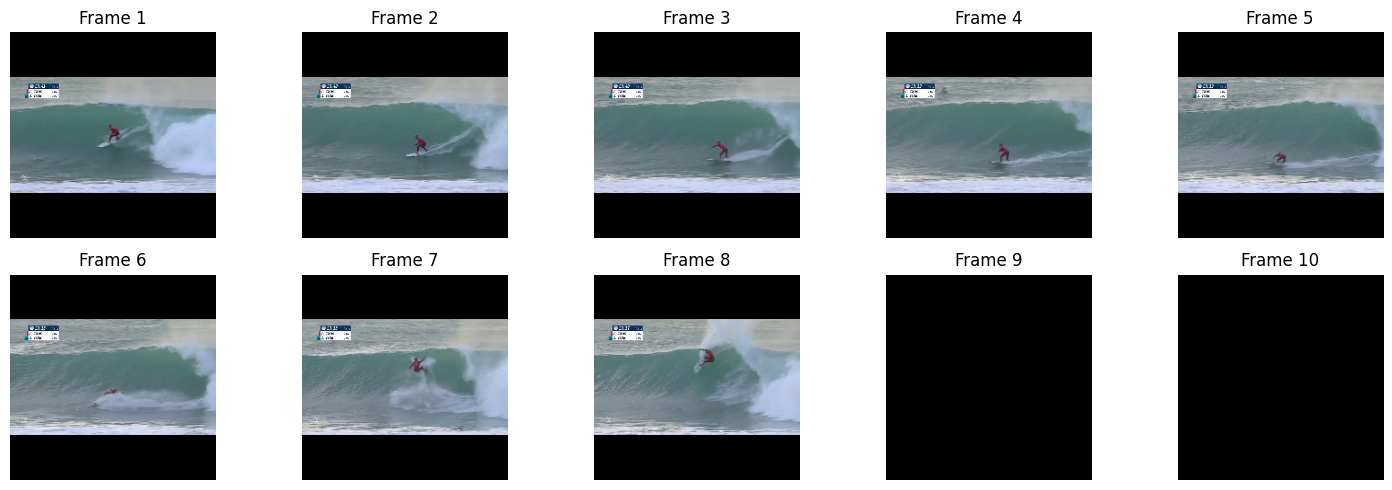

In [12]:
# Iterate and display frames for the first two videos
print("Displaying frames for the first two videos:")
video_count = 0
for batch_frames, batch_labels in teste_ds.take(2): # Take up to 2 batches
    for i in range(batch_frames.shape[0]): # Iterate through videos in the current batch
        if video_count >= 2:
            break

        print(f"Video {video_count + 1}:")
        current_video_frames = batch_frames[i]

        plt.figure(figsize=(15, 5))
        for j in range(current_video_frames.shape[0]): # Iterate through frames in the video
            plt.subplot(2, 5, j + 1) # Arrange 10 frames in 2 rows, 5 columns
            plt.imshow(current_video_frames[j])
            plt.title(f"Frame {j+1}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        video_count += 1
    if video_count >= 2:
        break